In [0]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import collections
import math
import pprint

from statistics import mean, variance, pvariance

In [30]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    root_path = './gdrive/Shared drives/Probstat'
except:
    root_path = './'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## SF Covid-19 Dataset

In [0]:
cases_df = pd.read_csv(root_path + '/data/COVID-19_Cases_Summarized_by_Date__Transmission_and_Case_Disposition.csv')

In [32]:
cases_df.isna().sum()

Date                     0
Transmission Category    0
Case Disposition         0
Case Count               0
dtype: int64

We can verify in above query, 0 MISSING values were found 

### Pre-processing steps for SF Covid-19 Dataset

1.   Converting Date column into date-time dtype



In [0]:
cases_df["Date"] = pd.to_datetime(cases_df["Date"], format="%Y/%m/%d")

2. Outlier Detection and Removal using Tukey's Rule:

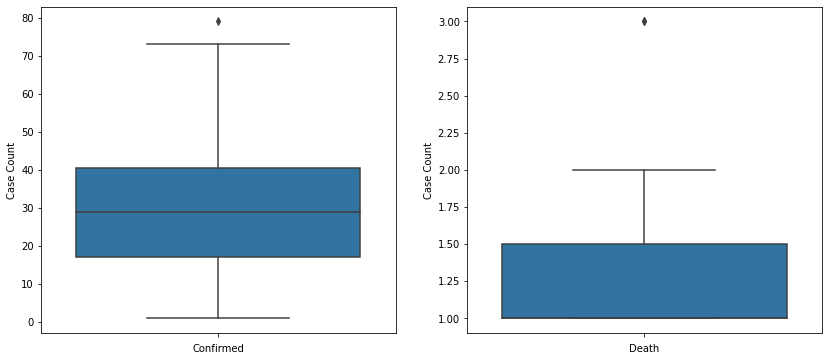

In [34]:
# Detect outliers for each type of data
types = ['Confirmed', 'Death']
outliers = {}
f, axes = plt.subplots(1, 2, figsize=[14, 6])
for i, t in enumerate(types):
    curr_df = cases_df[cases_df['Case Disposition'] == t].groupby(['Date'])['Case Count'].sum().reset_index()
    curr_ds = curr_df['Case Count']
    sns.boxplot(curr_ds, orient='v', ax=axes[i]).set(xlabel=t)
    Q1 = np.percentile(curr_ds, 25)
    Q3 = np.percentile(curr_ds, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers[t] = curr_df[(curr_ds < Q1 - outlier_step) | (curr_ds > Q3 + outlier_step)]

In [0]:
# Drop outlier rows
for t in outliers.keys():
    for d in set(outliers[t]['Date']):
        cases_df.drop(cases_df[(cases_df['Case Disposition'] == t) & (cases_df['Date'] == d)].index, inplace=True)

## SF Crime Dataset

In [0]:
crime_df = pd.read_csv(root_path + '/data/Police_Department_Incident_Reports__2018_to_Present.csv')

#### Checking missing/null values in Crime-Dataset

In [37]:
crime_df.isna().sum()

Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                               79225
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            269212
Incident Code                                                0
Incident Category                                          162
Incident Subcategory                                   

### Pre-processing steps for Crime Dataset:
1. Considering only non-null important Incident columns

In [0]:
columns_to_consider = ["Incident Datetime", 
                       "Incident Date", 
                       "Incident Time", 
                       "Incident Year", 
                       "Incident Day of Week", 
                       "Report Datetime", 
                       "Row ID", 
                       "Incident ID", 
                       "Incident Number", 
                       "Report Type Code", 
                       "Report Type Description", 
                       "Incident Code", 
                       "Incident Category", 
                       "Incident Subcategory", 
                       "Incident Description", 
                       "Resolution", 
                       "Police District"]

In [0]:
crime_df = crime_df[columns_to_consider]
crime_df = crime_df[crime_df["Incident Category"].notna()]

crime_df["Incident Date"] = pd.to_datetime(crime_df["Incident Date"], format="%Y/%m/%d")
crime_df["Incident Datetime"] = pd.to_datetime(crime_df["Incident Datetime"], format="%Y/%m/%d %I:%M:%S %p")

## Visualizations

In [0]:
def convert_agg_df_into_flatten_df(df):
    df = df.reset_index()
    df.columns = [' '.join(col).strip() for col in df.columns.values]

    return df

### Un-Smoothened and Smoothened crime cases by day
For smoothening purposes used Simple Moving Average spanning over a week

In [0]:
unique_crimes = crime_df.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()
unique_crimes.head()

date_freq = unique_crimes["Incident Date"].value_counts().to_frame().reset_index()
date_freq = date_freq.rename(columns={"index": "date", "Incident Date": "count"})
date_freq = date_freq.sort_values(by="date")

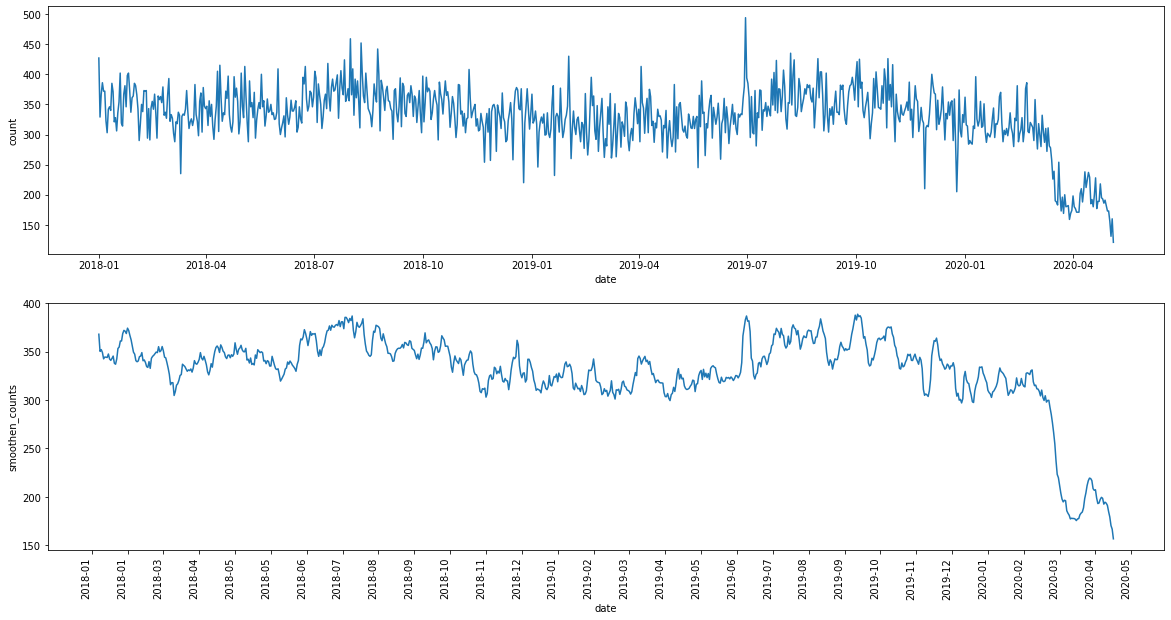

In [42]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', data=date_freq, ax=axes[0])


date_freq['smoothen_counts'] = date_freq['count'].rolling(window=7).mean()

sns_axes = sns.lineplot(x='date', y='smoothen_counts', data=date_freq, ax=axes[1])

# Adding x-ticks for each month
base_date = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')
dates = [base_date + datetime.timedelta(days=i * 30) for i in range(30)]
xfmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(xfmt)
axes[1].set_xticks(dates)

x_dates = [date.strftime("%Y-%m") for date in dates]
remnant = axes[1].set_xticklabels(labels=x_dates, rotation=90, ha='right')

### As we can see there's huge drop after first week of March 2020.
#### Because the first case of corona in San-Francisco was observed in 5th March, after which social-distancing measures were implemented

### Crimes filed Online vs Crimes filed related to Vehicle
See changes in trends of crime rates based on type of crime and filing status

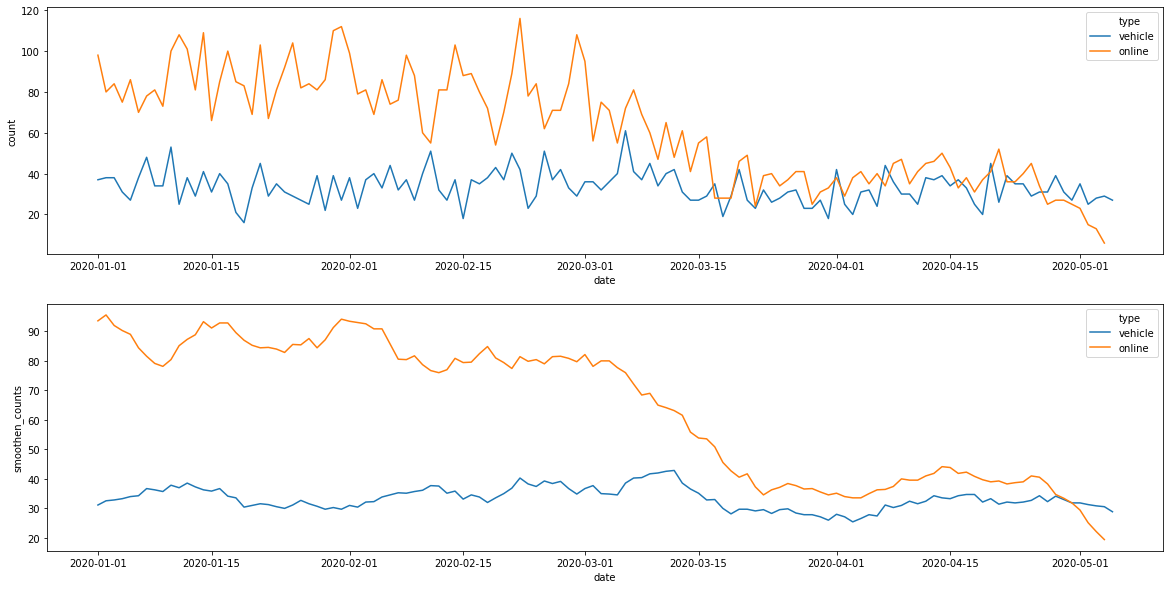

In [43]:
vehicle_unique_reports = crime_df[(crime_df["Report Type Description"] == "Vehicle Initial") |
                                  (crime_df["Report Type Description"] == "Vehicle Supplement")]
vehicle_unique_reports = vehicle_unique_reports.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()

online_unique_reports = crime_df[(crime_df["Report Type Description"] == "Coplogic Initial") |
                                             (crime_df["Report Type Description"] == "Coplogic Supplement")]
online_unique_reports = online_unique_reports.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()

vehicle_stats = vehicle_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
vehicle_stats = vehicle_stats.rename(columns={"index": "date", "Incident Date": "count"})
vehicle_stats = vehicle_stats.sort_values(by="date")
vehicle_stats['smoothen_counts'] = vehicle_stats['count'].rolling(window=7).mean()

online_stats = online_unique_reports["Incident Date"].value_counts().to_frame().reset_index()
online_stats = online_stats.rename(columns={"index": "date", "Incident Date": "count"})
online_stats = online_stats.sort_values(by="date")
online_stats['smoothen_counts'] = online_stats['count'].rolling(window=7).mean()

vehicle_stats["type"] = "vehicle"
online_stats["type"] = "online"

merged_df = pd.concat([vehicle_stats, online_stats])
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue="type", data=merged_df, ax=axes[0])

sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue="type", data=merged_df, ax=axes[1])

### Conclusion
As we can observe that the crime reports that are filed online are reduce but the crime reports filed regarding stolen vehicle are more or less same. <br>
The reason behind this is that most of the online crime reports filed by citizens are related to Lost property or Theft of Property (https://www.fdle.state.fl.us/FCJEI/Programs/SLP/Documents/Full-Text/Vandewater-final-paper.aspx) <br>
Also, in subsequent visualizations we find that Larceny Theft is the most frequent crime that is dropped. <br>
In summary, the most frequent crime Larceny (Theft of Property) which is filed online is dropped after corona has begun. May be this is because most of the people don't leave their houses so that they could be criminally occupied

In [0]:
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

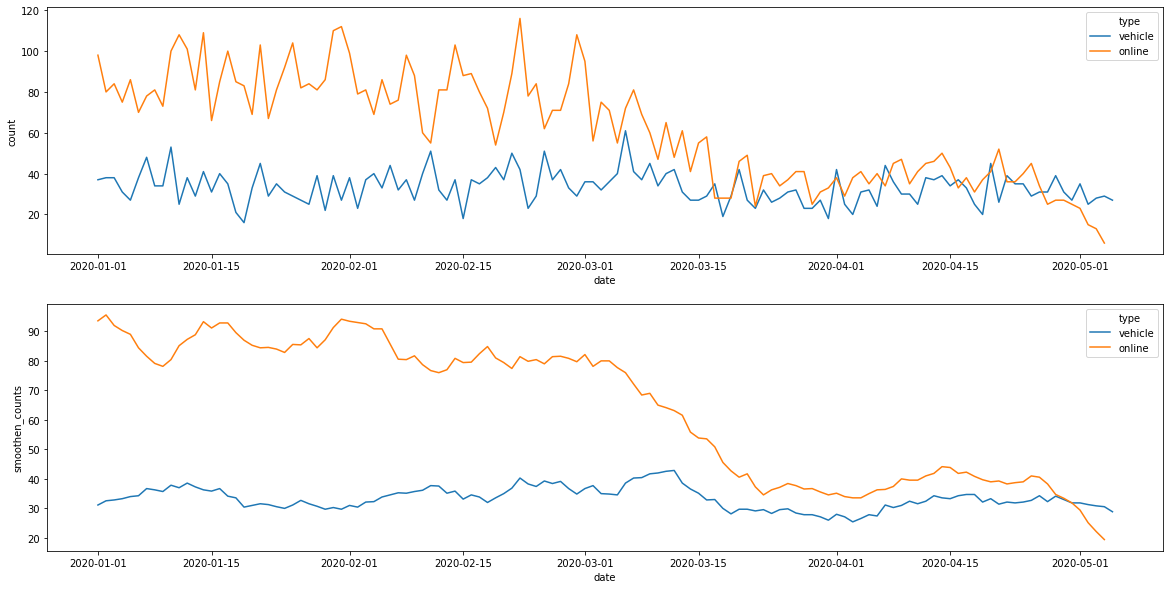

In [45]:
figure, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue="type", data=merged_df, ax=axes[0])

sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue="type", data=merged_df, ax=axes[1])

### Conclusion
We can observe that the crime reports that are filed online have reduced and the crime reports filed related to vehicles are more or less same. We expected online filing of crimes to increase during covid/lockdown period but that is not the case here. We also expected vehicle crimes to decrease since people would not be using their vehicles anymore but that does not seem to be the case either.

### Crime Rates Trend based on Crime Category
We look at some prominent types of crime incidents that are filed and observe their trends.

In [0]:
concern_cases = ["Larceny Theft", "Malicious Mischief", "Burglary",
                 "Motor Vehicle Theft", "Traffic Violation Arrest",
                 "Civil Sidewalks", "Traffic Collision", "Vandalism"]
df_list = []
# list(crime_df["Incident Category"].value_counts()[:10].index)
for case in concern_cases:
    case_level_df = crime_df[crime_df["Incident Category"] == case]
    case_level_df = case_level_df.groupby(["Incident ID"]).agg({"Incident Date": "first"}).reset_index()
     
    case_level_df = case_level_df["Incident Date"].value_counts().to_frame().reset_index()
    case_level_df = case_level_df.rename(columns={"index": "date", "Incident Date": "count"})
    case_level_df = case_level_df.sort_values(by="date")
    
    case_level_df['smoothen_counts'] = case_level_df['count'].rolling(window=14).mean()
    case_level_df['type'] = case
    
    df_list.append(case_level_df)
    
merged_df = pd.concat(df_list)

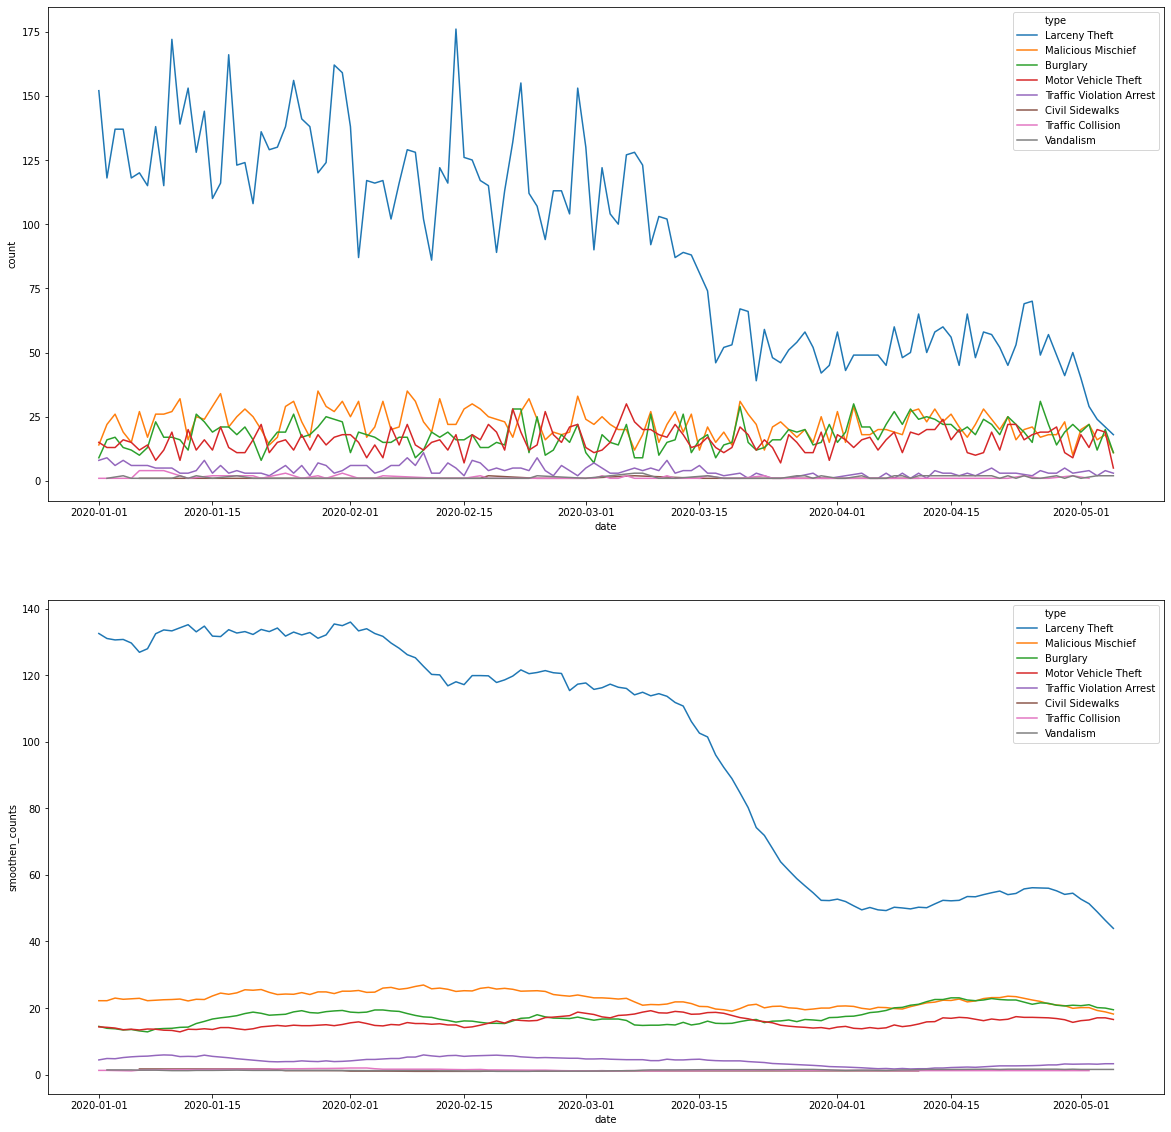

In [47]:
merged_df = merged_df[merged_df["date"] > datetime.datetime(2019, 12, 31)]

figure, axes = plt.subplots(figsize=(20, 20), nrows=2, ncols=1)
sns.lineplot(x='date', y='count', hue='type', data=merged_df, ax=axes[0])


sns_axes = sns.lineplot(x='date', y='smoothen_counts', hue='type', data=merged_df, ax=axes[1])


## Conclusion:
1. Crime rates have been more or less same for all crimes except Larceny Theft and Traffic Violation Arrest
2. We believe the rates for Traffic Violation Arrest have reduced because very few people are driving on streets since the month of March
3. Larceny Theft is the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another. We believe since majority of people after March are staying at home and so are in physical possession of their belongings, there are fewer reports for arceny thefts.

# Required Inference 1
## Time series analysis for COVID19 data 
AR(3), AR(5), EWMA(0.5), EWMA(0.8) - For fatalities and number of cases

In [48]:
# Group the data by Case Disposition(Death, New Case) and Date
cases_df_grouped = cases_df.groupby(by=['Case Disposition', 'Date'])

# Search for the start date and end date in the data
start_date = cases_df['Date'].min()
end_date = cases_df['Date'].max()

# Calculate the total number of days based on start date and end date
num_of_days = end_date - start_date
num_of_days = num_of_days.days + 1

# Prepare a list of number of cases and deaths where index = index of the day from start date
num_cases_list = [ 0 for i in range(num_of_days)]
deaths_list = [0 for i in range(num_of_days)]

# Iterate through the groups of data to extract number of cases and fatalities 
# to store in a list
for name, group in cases_df_grouped:
  if name[0] == 'Confirmed':
    num_cases_list[(group['Date'].min() - start_date).days] = group['Case Count'].sum()
  else:
    deaths_list[(group['Date'].min()- start_date).days] = group['Case Count'].sum()


# Function to predict Auto Regression (AR) prediction values
def predict_ar(AR_p, day_of_the_week):

  training_data_count = num_of_days - 7 - AR_p + day_of_the_week

  x_num_cases = [[0 for i in range(AR_p+1)] for i in range(training_data_count)]
  y_num_cases = [ 0 for i in range(training_data_count) ]

  x_deaths = [[0 for i in range(AR_p+1)] for i in range(training_data_count)]
  y_deaths = [ 0 for i in range(training_data_count) ]
  for i in range(training_data_count):
    x_num_cases[i][0] = 1
    y_num_cases[i] = num_cases_list[i+AR_p]

    x_deaths[i][0] = 1
    y_deaths[i] = deaths_list[i+AR_p]

    for j in range(AR_p):
      x_num_cases[i][AR_p - j] = num_cases_list[i+j]
      x_deaths[i][AR_p - j] = deaths_list[i+j]

  # Prepare the X-matrix for prediction for number of casees and deaths
  x_pred_num_of_cases = [0 for i in range(AR_p+1)]
  x_pred_num_of_cases[0] = 1
  x_pred_deaths = [0 for i in range(AR_p+1)]
  x_pred_deaths[0] = 1

  for i in range(AR_p):
    x_pred_num_of_cases[i+1] = num_cases_list[training_data_count+AR_p-1-i]
    x_pred_deaths[i+1] = deaths_list[training_data_count+AR_p-1-i]
  
  x_num_cases = np.array(x_num_cases)
  x_deaths = np.array(x_deaths)

  beta_num_cases = [0 for i in range(AR_p+1)]
  x_num_cases_transpose = np.matrix.transpose(x_num_cases)
  # Calculate the beta matrix for number of cases by the formula: beta = (inverse(X_transpose*X))*(X_transpose)*(Y)
  beta_num_cases = np.dot(np.dot(np.linalg.inv(np.dot(x_num_cases_transpose, x_num_cases)), x_num_cases_transpose), y_num_cases)

  beta_deaths = [0 for i in range(AR_p+1)]
  x_deaths_transpose = np.matrix.transpose(x_deaths)
  # Calculate the beta matrix for deaths by the formula: beta = (inverse(X_transpose*X))*(X_transpose)*(Y)
  beta_deaths = np.dot(np.dot(np.linalg.inv(np.dot(x_deaths_transpose, x_deaths)), x_deaths_transpose), y_deaths)

  # Calculate the predicted number of cases and deaths by the formula: Y = beta*X
  y_pred_num_cases = np.dot(x_pred_num_of_cases, beta_num_cases)
  y_pred_deaths = np.dot(x_pred_deaths, beta_deaths)

  return y_pred_num_cases, y_pred_deaths, num_cases_list[training_data_count+AR_p], deaths_list[training_data_count+AR_p]


# Function to predict the EWMA estimates 
def predict_ewma(alpha):

  y_pred_num_cases = [0 for i in range(len(num_cases_list))]
  y_pred_deaths = [0 for i in range(len(deaths_list))]

  # Calculate the initial predicted value as the actual value itself
  y_pred_num_cases[0] = num_cases_list[0]
  y_pred_deaths[0] = deaths_list[0]

  # For subsequent predictions, use the formula: alpha*(y_t) + (1-alpha)*(y_hat_t)
  for i in range(1,len(num_cases_list)):
    y_pred_num_cases[i] = round((alpha*num_cases_list[i-1] + (1-alpha)*y_pred_num_cases[i-1]), 2)
    y_pred_deaths[i] = round((alpha*deaths_list[i-1] + (1-alpha)*y_pred_deaths[i-1]), 2)

  return y_pred_num_cases[-7:], y_pred_deaths[-7:]

# Function to calculate MAPE and MSE values 
def calculate_mape_and_mse(y_pred_num_cases, y_num_cases, y_pred_deaths, y_deaths):
  mape_num_cases = 0
  mse_num_cases = 0

  mape_deaths = 0
  mse_deaths = 0
  for i in range(len(y_num_cases)):
    # Calculate MAPE for number of cases
    # Drop the cases when the actual value is zero
    if y_num_cases[i] != 0:
      mape_num_cases = mape_num_cases + (abs(y_num_cases[i] - y_pred_num_cases[i]))/y_num_cases[i]
    # Calculate MAPE for deaths
    # Drop the cases when the actual value is zero
    if y_deaths[i] != 0:
      mape_deaths = mape_deaths + (abs(y_deaths[i] - y_pred_deaths[i]))/y_deaths[i]
    # Calculate MSE for number of cases
    mse_num_cases = mse_num_cases + (y_num_cases[i] - y_pred_num_cases[i])*(y_num_cases[i] - y_pred_num_cases[i])
    # Calcuate MSE for deaths
    mse_deaths = mse_deaths + (y_deaths[i] - y_pred_deaths[i])*(y_deaths[i] - y_pred_deaths[i]) 
  mape_num_cases = (mape_num_cases*100)/len(y_num_cases)
  mape_deaths = (mape_deaths*100)/len(y_num_cases)
  mse_num_cases = mse_num_cases/len(y_num_cases)
  mse_deaths - mse_deaths/len(y_num_cases)

  mape_list = []
  mape_list.append(mape_num_cases)
  mape_list.append(mape_deaths)
  mse_list = []
  mse_list.append(mse_num_cases)
  mse_list.append(mse_deaths)

  return mape_list, mse_list


# Make empty lists to store the actual and predicted values for fatalities and number 
# of cases for last 1 week for AR(3), AR(5), EWMA(0.5), EWMA(0.8)
y_num_cases_7_days = []
y_deaths_7_days = []
y_pred_num_cases_7_days_ar_3 = []
y_pred_deaths_7_days_ar_3 = []
y_pred_num_cases_7_days_ar_5 = []
y_pred_deaths_7_days_ar_5 = []
y_pred_num_cases_ewma_5 = []
y_pred_deaths_ewma_5 = []
y_pred_num_cases_ewma_8 = []
y_pred_deaths_ewma_8 = []


# Call the functions to get the results 
for i in range(7):
  # Get the predictions for AR(3) for fatalities and number of cases for last 1 week
  results = predict_ar(3, i)
  y_pred_num_cases_7_days_ar_3.append(round(results[0],2))
  y_pred_deaths_7_days_ar_3.append(round(results[1],2))
  y_num_cases_7_days.append(results[2])
  y_deaths_7_days.append(results[3])

  # Get the predictions for AR(5) for fatalities and number of cases for last 1 week
  results_1 = predict_ar(5, i)
  y_pred_num_cases_7_days_ar_5.append(round(results_1[0],2))
  y_pred_deaths_7_days_ar_5.append(round(results_1[1],2))

# Get the predictions for EWMA(alpha=0.5) for fatalities and number of cases for last 1 week
y_pred_num_cases_ewma_5, y_pred_deaths_ewma_5 = predict_ewma(0.5)
# Get the predictions for EWMA(alpha=0.8) for fatalities and number of cases for last 1 week
y_pred_num_cases_ewma_8, y_pred_deaths_ewma_8 = predict_ewma(0.8)

# Calculate MAPE and MSE values for AR(3)
mape_ar_3, mse_ar_3 = calculate_mape_and_mse(y_pred_num_cases_7_days_ar_3, y_num_cases_7_days, y_pred_deaths_7_days_ar_3, y_deaths_7_days)
# Calculate MAPE and MSE values for AR(5)
mape_ar_5, mse_ar_5 = calculate_mape_and_mse(y_pred_num_cases_7_days_ar_5, y_num_cases_7_days, y_pred_deaths_7_days_ar_5,  y_deaths_7_days)
# Calculate MAPE and MSE values for EWMA with alpha 0.5
mape_ewma_5, mse_ewma_5 = calculate_mape_and_mse(y_pred_num_cases_ewma_5, y_num_cases_7_days, y_pred_deaths_ewma_5,  y_deaths_7_days)
# Calculate MAPE and MSE values for EWMA with alpha 0.8
mape_ewma_8, mse_ewma_8 = calculate_mape_and_mse(y_pred_num_cases_ewma_8, y_num_cases_7_days, y_pred_deaths_ewma_8, y_deaths_7_days)

print("Actual number of new cases for the last week(day1 - day7): "+str(y_num_cases_7_days))
print("Actual number of deaths for the last week: "+ str(y_deaths_7_days))
print()
print("Autoregression(3) number of cases prediction for the last week: "+str(y_pred_num_cases_7_days_ar_3))
print("Autoregression(3) deaths prediction for the last week: "+str(y_pred_deaths_7_days_ar_3))
print()
print("Autoregression(5) number of cases prediction for the last week: "+str(y_pred_num_cases_7_days_ar_5))
print("Autoregression(5) deaths prediction for the last week: "+str(y_pred_deaths_7_days_ar_5))
print()
print("EWMA with alpha 0.5 number of cases prediction for the last week: "+ str(y_pred_num_cases_ewma_5))
print("EWMA with alpha 0.5 deaths prediction for the last week: "+str(y_pred_deaths_ewma_5))
print()
print("EWMA with alpha 0.8 number of cases prediction for the last week: "+str(y_pred_num_cases_ewma_8))
print("EWMA with alpha 0.8 deaths prediction for the last week: "+str(y_pred_deaths_ewma_8))
print()
print("MAPE for AR(3) for number of cases: "+str(round(mape_ar_3[0],2)))
print("MAPE for AR(3) for deaths: "+str(round(mape_ar_3[1],2)))
print("MSE for AR(3) for number of cases: "+str(round(mse_ar_3[0],2)))
print("MSE for AR(3) for deaths: "+str(round(mse_ar_3[1],2)))
print()
print("MAPE for AR(5) for number of cases: "+str(round(mape_ar_5[0],2)))
print("MAPE for AR(5) for deaths: "+str(round(mape_ar_5[1],2)))
print("MSE for AR(5) for number of cases: "+str(round(mse_ar_5[0],2)))
print("MSE for AR(5) for deaths: "+str(round(mse_ar_5[1],2)))
print()
print("MAPE for EWMA with alpha 0.5 for number of cases: "+str(round(mape_ewma_5[0],2)))
print("MAPE for EWMA with alpha 0.5 for deaths: "+str(round(mape_ewma_5[1],2)))
print("MSE for EWMA with alpha 0.5 for number of cases: "+str(round(mse_ewma_5[0],2)))
print("MSE for EWMA with alpha 0.5 for deaths: "+str(round(mse_ewma_5[1],2)))
print()
print("MAPE for EWMA with alpha 0.8 for number of cases: "+str(round(mape_ewma_8[0],2)))
print("MAPE for EWMA with alpha 0.8 for deaths: "+str(round(mape_ewma_8[1],2)))
print("MSE for EWMA with alpha 0.8 for number of cases: "+str(round(mse_ewma_8[0],2)))
print("MSE for EWMA with alpha 0.8 for deaths: "+str(round(mse_ewma_8[1],2)))

Actual number of new cases for the last week(day1 - day7): [29, 50, 38, 73, 40, 6, 1]
Actual number of deaths for the last week: [1, 2, 1, 0, 0, 0, 0]

Autoregression(3) number of cases prediction for the last week: [33.75, 34.4, 36.85, 35.97, 49.12, 45.97, 35.07]
Autoregression(3) deaths prediction for the last week: [0.67, 0.38, 0.49, 0.6, 0.9, 0.63, 0.27]

Autoregression(5) number of cases prediction for the last week: [35.13, 34.12, 36.5, 37.91, 45.28, 43.06, 38.19]
Autoregression(5) deaths prediction for the last week: [0.67, 0.33, 0.49, 0.46, 0.83, 0.74, 0.48]

EWMA with alpha 0.5 number of cases prediction for the last week: [36.8, 32.9, 41.45, 39.72, 56.36, 48.18, 27.09]
EWMA with alpha 0.5 deaths prediction for the last week: [0.14, 0.57, 1.28, 1.14, 0.57, 0.28, 0.14]

EWMA with alpha 0.8 number of cases prediction for the last week: [36.62, 30.52, 46.1, 39.62, 66.32, 45.26, 13.85]
EWMA with alpha 0.8 deaths prediction for the last week: [0.03, 0.81, 1.76, 1.15, 0.23, 0.05, 0.

## Assumption: 

There were a couple of days in Number of Cases data, where there was no entry. There were many entries in Deaths data for which there was no entry. We have assumed zero cases and deaths for such days and made predictions accordingly.

# Actual values:
## Number of cases ( Day 1, ...., Day 7 ): 
29, 50, 38, 73, 40, 6, 1

## Deaths: 
1, 2, 1, 0, 0, 0, 0

# Predicted values:

## AR(3)

### Number of cases: 
31.31, 32.14, 44.89, 36.4, 57.34, 33.89, 15.7

### Deaths: 
0.52, 0.68, 0.82, 0.52, 0.44, 0.5, 0.44

## AR(5)

### Number of cases:
35.86, 29.7, 44.9, 41.11, 51.04, 34.02, 15.66

### Deaths:
0.44, 0.62, 0.86, 0.37, 0.36, 0.65, 0.74


## EWMA ( alpha = 0.5 )

### Number of cases:
36.8, 32.9, 41.45, 39.72, 56.36, 48.18, 27.09

### Deaths:
0.14, 0.57, 1.28, 1.14, 0.57, 0.28, 0.14


## EWMA ( alpha = 0.8 ) 

### Number of cases: 
36.62, 30.52, 46.1, 39.62, 66.32, 45.26, 13.85

### Deaths:
0.03, 0.81, 1.76, 1.15, 0.23, 0.05, 0.01




# MAPE and MSE 
(Note: Records where actual value is 0 is disregarded in MAPE calculation)

## AR(3)
MAPE for number of cases: 298.59

MAPE for deaths: 18.86

MSE for number of cases: 429.42

MSE for deaths: 2.91

## AR(5) 

MAPE for number of cases: 298.1

MAPE for deaths: 19.86

MSE for number of cases: 377.95

MSE for deaths: 3.47

## EWMA ( alpha = 0.5 )

MAPE for number of cases: 495.52

MAPE for deaths: 26.5

MSE for number of cases: 600.03

MSE for deaths: 4.59

## EWMA ( alpha = 0.8 )

MAPE for number of cases: 305.34

MAPE for deaths: 33.21

MSE for number of cases: 573.8

MSE for deaths: 4.31


## Comments

For AR(3) and AR(5), we do not see a considerable difference in predictions for both number of cases and deaths. The MAPE and MSE for those techniques are also very similar. The EWMA (alpha=0.5) and EWMA(alpha=0.8) also predict similar values for most of the number of cases and deaths in the week, but are relatively less accurate. 


Generally, comparing the accuracy of all the techniques, AR seems much better than EWMA. Among all the performed techniques, the smallest MAPE percentage for both number of cases and deaths is observed for AR(3). The smallest MSE for number of cases is observed for AR(5), while the smallest MSE for deaths is observed for AR(3).  


The reason for such high MAPE and MSE for number of cases is the unusual actual numbers in San Francisco. The numbers are getting surprisingly low or are increasing with much slower rate than other places. Hence, the prediction will predict high values for number of cases and deaths, but the actual value is very low. For example, the number of cases for last 2 days is 6 and 1. 
For AR(3), the predictions are 33.89 and 15.7, which will give the percentage error as approx. 450 % and 1400 %. This will skew the MAPE values. 

# Required Inference 2

In [0]:
from datetime import timedelta

## Inferences for Deaths

In [0]:
# Filter death cases and compute death counts
death_cases = cases_df[cases_df['Case Disposition'] == 'Death']
death_counts = death_cases.groupby('Date')['Case Count'].sum().reset_index()

In [0]:
# Get the latest date in the data and compute last week and second last week date
latest_date = death_counts.sort_values(by='Date', ascending=False)['Date'].iloc[0]

last_week_date = latest_date - timedelta(weeks=1)
second_last_week_date = last_week_date - timedelta(weeks=1)

In [0]:
# Get death counts in last week imputing 0 value for missing dates and store in X
last_week_death_counts = death_counts[death_counts['Date'] > last_week_date]
X = []
for i in range(1, 8):
    curr_date = (last_week_date + timedelta(days=i))
    if curr_date not in set(last_week_death_counts['Date']):
        X.append(0)
    else:
        X.append(last_week_death_counts[last_week_death_counts['Date'] == curr_date]['Case Count'].iloc[0])
X = np.array(X)

In [0]:
# Get death counts in second last week imputing 0 value for missing dates and store in Y
second_last_week_death_counts = death_counts.loc[(death_counts['Date'] > second_last_week_date) & (death_counts['Date'] <= last_week_date)]
Y = []
for i in range(1, 8):
    curr_date = (second_last_week_date + timedelta(days=i))
    if curr_date not in set(second_last_week_death_counts['Date']):
        Y.append(0)
    else:
        Y.append(second_last_week_death_counts[second_last_week_death_counts['Date'] == curr_date]['Case Count'].iloc[0])
Y = np.array(Y)

### Wald's Test
For all the tests in required inference 2, $\mu_x$: Mean of last week data and $\mu_y$: Mean of second last week data
#### One sample test
Hypotheses:  
$H_0: \mu = \mu_0$  
$H_1: \mu \neq \mu_0$  
$\mu$: Mean of last week data and $\mu_0$: Mean of second last week data

Assuming the original distribution is Poission($\lambda$), we get  
$\hat\mu_{MLE} = \hat\lambda_{MLE} = \bar X$ and  
$\hat se(\hat\mu) = \sqrt{Var(\bar X)} = \sqrt{\frac{Var(X)}{n}} = \sqrt{\frac{\hat\lambda_{MLE}}{n}} = \sqrt{\frac{\bar X}{n}}$

In [0]:
n = len(X)

mu_hat = np.mean(X)
mu_0 = np.mean(Y)
sample_variance = np.mean(X)
se_hat = np.sqrt(sample_variance / n)

In [0]:
w = np.abs((mu_hat - mu_0) / se_hat)

In [56]:
w

1.3416407864998738

For $\alpha = 0.05$, $Z_{\alpha/2} = 1.96$  
Since the Wald's statistic $|w| \leq Z_{\alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu = \mu_0$

**Comment**: If given the true distribution is Poisson, Wald's test is applicable here, since we are using MLE estimator for mean of Poisson which is Asymtotically Normal. If we don't know the true distribution then Wald's test may not be applicable as we cannot compute the MLE estimator for mean.

#### Two sample test
Hypotheses:  
$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$

Similar to one sample test, assuming the original distributions are Poisson($\lambda_x$) and Poisson($\lambda_y$) distributed, we get  
$\hat \mu_x = \bar X$ , $\hat \mu_y = \bar Y$ and  
$\hat se(\hat \mu_x) = \sqrt{\frac{\bar X}{n}}$ , $\hat se(\hat \mu_y) = \sqrt{\frac{\bar Y}{m}}$

In [0]:
n = len(X)
m = len(Y)

mu_x = np.mean(X)
mu_y = np.mean(Y)
sample_variance_x = np.mean(X)
sample_variance_y = np.mean(Y)
se_hat = np.sqrt(sample_variance_x / n + sample_variance_y / m)

In [0]:
w = np.abs((mu_x - mu_y) / se_hat)

In [59]:
w

1.133893419027682

For $\alpha = 0.05$, $Z_{\alpha/2} = 1.96$  
Since the Wald's statistic $|w| \leq Z_{\alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Comment**: Similar to one sample test, if given the true distribution is Poisson, Wald's test is applicable here, since we are using MLE estimator for mean of Poisson which is Asymtotically Normal. If we don't know the true distribution then Wald's test may not be applicable as we cannot compute the MLE estimator for mean.

### T Test
#### One sample test
Hypotheses:  
$H_0: \mu = \mu_0$  
$H_1: \mu \neq \mu_0$

In [0]:
n = len(X)

X_bar = np.mean(X)
mu_0 = np.mean(Y)
sample_variance = 1/n * np.sum(np.square(X - X_bar))
se_hat = np.sqrt(sample_variance / n)

In [61]:
t = np.abs((X_bar - mu_0) / se_hat)
t

1.6201851746019653

For $\alpha = 0.05$ and $df = 6$, $t_{df,\alpha/2} = 2.447$  
Since the T's statistic $|t| \leq t_{n-1, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu = \mu_0$

**Comment**: T Test is only applicable when the distribution X is a Normal Distribution. Since we don't know the original distribution and can't assume it to be Normal, this test is not applicable here.

### Two sample test (Paired)
Hypotheses:  
$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$  
$D_i = X_i - Y_i$  

In [0]:
D = X - Y

In [0]:
n = len(D)

D_bar = np.mean(D)
sample_variance_d = 1/n * np.sum(np.square(D - D_bar))
se_hat = np.sqrt(sample_variance_d / n)

In [64]:
t = np.abs(D_bar / se_hat)
t

1.5566235649883124

For $\alpha = 0.05$ and $df = 6$, $t_{df,\alpha/2} = 2.447$  
Since the T's statistic $|t| \leq t_{n-1, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Comment**: Paired T Test is only applicable when the distribution D is a Normal Distribution. Since we don't know the original distributions X and Y, we can't assume (X - Y) to be Normal either and so this test is not applicable here.

### Two sample test (Unpaired)
Hypotheses:  
$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$  
$\bar D= \bar X - \bar Y$  

In [0]:
n = len(X)
m = len(Y)

X_bar = np.mean(X)
Y_bar = np.mean(Y)
sample_variance_x = 1/n * np.sum(np.square(X - X_bar))
sample_variance_y = 1/m * np.sum(np.square(Y - Y_bar))
se_hat = np.sqrt(sample_variance_x / n + sample_variance_y / m)

In [66]:
t = np.abs((X_bar - Y_bar) / se_hat)
t

1.3612278194595453

For $\alpha = 0.05$ and $df = n+m-2 = 12$, $t_{df,\alpha/2} = 2.179$  
Since the T's statistic $|t| \leq t_{n+m-2, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Comment**: Unpaired T Test is only applicable when the distributions X and Y are a Normal Distribution. Since we don't know the original distributions X and Y, we can't assume them to be Normal either and so this test is not applicable here.

### Z-test
#### One sample test
Hypotheses:  
$H_0: \mu = \mu_0$  
$H_1: \mu \neq \mu_0$


In [0]:
# Get all the values for deaths into X_all
first_date = cases_df.sort_values(by='Date', ascending=True)['Date'].iloc[0]
last_date = cases_df.sort_values(by='Date', ascending=False)['Date'].iloc[0]
X_all = []
i = 0
while (first_date + timedelta(days=i)) <= last_date:
    curr_date = (first_date + timedelta(days=i))
    if curr_date not in set(death_counts['Date']):
        X_all.append(0)
    else:
        X_all.append(death_counts[death_counts['Date'] == curr_date]['Case Count'].iloc[0])
    i += 1
X_all = np.array(X_all)

In [0]:
# Compute true variance using sample variance of entire available data
X_all_bar = np.mean(X_all)
true_variance = 1/len(X_all) * np.sum(np.square(X_all - X_all_bar))

In [0]:
n = len(X)

X_bar = np.mean(X)
mu_0 = np.mean(Y)
se_hat = np.sqrt(true_variance / n)

In [70]:
z = np.abs((X_bar - mu_0) / se_hat)
z

1.8565529354090937

For $\alpha = 0.05$, $Z_{\alpha/2} = 1.96$  
Since the Z statistic $|z| \leq Z_{\alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu = \mu_0$

**Comment**: Z Test is only applicable when n is large so that it follows Central Limit Theorem but since n is small here <30, Z test is not applicable here

## Inferences for Cases
All inferences for confirmed cases are similar to that of death cases in terminology and applicability

In [0]:
# Filter confirmed cases and compute cases counts
confirmed_cases = cases_df[cases_df['Case Disposition'] == 'Confirmed']
cases_counts = confirmed_cases.groupby('Date')['Case Count'].sum().reset_index()

In [0]:
# Get the latest date in the data and compute last week and second last week date
latest_date = cases_counts.sort_values(by='Date', ascending=False)['Date'].iloc[0]

last_week_date = latest_date - timedelta(weeks=1)
second_last_week_date = last_week_date - timedelta(weeks=1)

In [0]:
# Get cases counts in last week imputing 0 value for missing dates and store in X
last_week_cases_counts = cases_counts[cases_counts['Date'] > last_week_date]
X = []
for i in range(1, 8):
    curr_date = (last_week_date + timedelta(days=i))
    if curr_date not in set(last_week_cases_counts['Date']):
        X.append(0)
    else:
        X.append(last_week_cases_counts[last_week_cases_counts['Date'] == curr_date]['Case Count'].iloc[0])
X = np.array(X)

In [0]:
# Get cases counts in second last week imputing 0 value for missing dates and store in Y
second_last_week_cases_counts = cases_counts.loc[(cases_counts['Date'] > second_last_week_date) & (cases_counts['Date'] <= last_week_date)]
Y = []
for i in range(1, 8):
    curr_date = (second_last_week_date + timedelta(days=i))
    if curr_date not in set(second_last_week_cases_counts['Date']):
        Y.append(0)
    else:
        Y.append(second_last_week_cases_counts[second_last_week_cases_counts['Date'] == curr_date]['Case Count'].iloc[0])
Y = np.array(Y)

### Wald's Test
#### One sample test
Hypotheses:  
$H_0: \mu = \mu_0$  
$H_1: \mu \neq \mu_0$

Assuming the original distribution is Poission($\lambda$), we get  
$\hat\mu_{MLE} = \hat\lambda_{MLE} = \bar X$ and  
$\hat se(\hat\mu) = \sqrt{Var(\bar X)} = \sqrt{\frac{Var(X)}{n}} = \sqrt{\frac{\hat\lambda_{MLE}}{n}} = \sqrt{\frac{\bar X}{n}}$

In [0]:
n = len(X)

mu_hat = np.mean(X)
mu_0 = np.mean(Y)
sample_variance = np.mean(X)
se_hat = np.sqrt(sample_variance / n)

In [0]:
w = np.abs((mu_hat - mu_0) / se_hat)

In [77]:
w

0.06495698024616126

For $\alpha = 0.05$, $Z_{\alpha/2} = 1.96$  
Since the Wald's statistic $|w| \leq Z_{\alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu = \mu_0$

**Comment**: If given the true distribution is Poisson, Wald's test is applicable here, since we are using MLE estimator for mean of Poisson which is Asymtotically Normal. If we don't know the true distribution then Wald's test may not be applicable as we cannot compute the MLE estimator for mean.

#### Two sample test
Hypotheses:  
$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$

Similar to one sample test, assuming the original distributions are Poisson($\lambda_x$) and Poisson($\lambda_y$) distributed, we get  
$\hat \mu_x = \bar X$ , $\hat \mu_y = \bar Y$ and  
$\hat se(\hat \mu_x) = \sqrt{\frac{\bar X}{n}}$ , $\hat se(\hat \mu_y) = \sqrt{\frac{\bar Y}{m}}$

In [0]:
n = len(X)
m = len(Y)

mu_x = np.mean(X)
mu_y = np.mean(Y)
sample_variance_x = np.mean(X)
sample_variance_y = np.mean(Y)
se_hat = np.sqrt(sample_variance_x / n + sample_variance_y / m)

In [0]:
w = np.abs((mu_x - mu_y) / se_hat)

In [80]:
w

0.04598004898716898

For $\alpha = 0.05$, $Z_{\alpha/2} = 1.96$  
Since the Wald's statistic $|w| \leq Z_{\alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Comment**: Similar to one sample test, if given the true distribution is Poisson, Wald's test is applicable here, since we are using MLE estimator for mean of Poisson which is Asymtotically Normal. If we don't know the true distribution then Wald's test may not be applicable as we cannot compute the MLE estimator for mean.

### T Test
#### One sample test
Hypotheses:  
$H_0: \mu = \mu_0$  
$H_1: \mu \neq \mu_0$

In [0]:
n = len(X)

X_bar = np.mean(X)
mu_0 = np.mean(Y)
sample_variance = 1/n * np.sum(np.square(X - X_bar))
se_hat = np.sqrt(sample_variance / n)

In [82]:
t = np.abs((X_bar - mu_0) / se_hat)
t

0.016380555559238546

For $\alpha = 0.05$ and $df = 6$, $t_{df,\alpha/2} = 2.447$  
Since the T's statistic $|t| \leq t_{n-1, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu = \mu_0$

**Comment**: T Test is only applicable when the distribution X is a Normal Distribution. Since we don't know the original distribution and can't assume it to be Normal, this test is not applicable here.

### Two sample test (Paired)
Hypotheses:  
$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$  
$D_i = X_i - Y_i$  

In [0]:
D = X - Y

In [0]:
n = len(D)

D_bar = np.mean(D)
sample_variance_d = 1/n * np.sum(np.square(D - D_bar))
se_hat = np.sqrt(sample_variance_d / n)

In [85]:
t = np.abs(D_bar / se_hat)
t

0.014663360102648319

For $\alpha = 0.05$ and $df = 6$, $t_{df,\alpha/2} = 2.447$  
Since the T's statistic $|t| \leq t_{n-1, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Comment**: Paired T Test is only applicable when the distribution D is a Normal Distribution. Since we don't know the original distributions X and Y, we can't assume (X - Y) to be Normal either and so this test is not applicable here.

### Two sample test (Unpaired)
Hypotheses:  
$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$  
$\bar D= \bar X - \bar Y$  

In [0]:
n = len(X)
m = len(Y)

X_bar = np.mean(X)
Y_bar = np.mean(Y)
sample_variance_x = 1/n * np.sum(np.square(X - X_bar))
sample_variance_y = 1/m * np.sum(np.square(Y - Y_bar))
se_hat = np.sqrt(sample_variance_x / n + sample_variance_y / m)

In [87]:
t = np.abs((X_bar - Y_bar) / se_hat)
t

0.01557510400310378

For $\alpha = 0.05$ and $df = n+m-2 = 12$, $t_{df,\alpha/2} = 2.179$  
Since the T's statistic $|t| \leq t_{n+m-2, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Comment**: Unpaired T Test is only applicable when the distributions X and Y are a Normal Distribution. Since we don't know the original distributions X and Y, we can't assume them to be Normal either and so this test is not applicable here.

### Z-test
#### One sample test
Hypotheses:  
$H_0: \mu = \mu_0$  
$H_1: \mu \neq \mu_0$


In [0]:
# Get all the values for confirmed cases into X_all
first_date = cases_df.sort_values(by='Date', ascending=True)['Date'].iloc[0]
last_date = cases_df.sort_values(by='Date', ascending=False)['Date'].iloc[0]
X_all = []
i = 0
while (first_date + timedelta(days=i)) <= last_date:
    curr_date = (first_date + timedelta(days=i))
    if curr_date not in set(cases_counts['Date']):
        X_all.append(0)
    else:
        X_all.append(cases_counts[cases_counts['Date'] == curr_date]['Case Count'].iloc[0])
    i += 1
X_all = np.array(X_all)

In [0]:
# Compute true variance using sample variance of entire available data
X_all_bar = np.mean(X_all)
true_variance = 1/len(X_all) * np.sum(np.square(X_all - X_all_bar))

In [0]:
n = len(X)

X_bar = np.mean(X)
mu_0 = np.mean(Y)
se_hat = np.sqrt(true_variance / n)

In [91]:
z = np.abs((X_bar - mu_0) / se_hat)
z

0.020585958915601166

For $\alpha = 0.05$, $Z_{\alpha/2} = 1.96$  
Since the Z statistic $|z| \leq Z_{\alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu = \mu_0$

**Comment**: Z Test is only applicable when n is large so that it follows Central Limit Theorem but since n is small here <30, Z test is not applicable here

# Required Inference 3
### KS Test (1-Sample and 2-Sample )and Permutation Test analysis for COVID19 \#Case and \#Deaths  


## Load COVID Data

In [92]:
def loadCovidDataset(): 
    #  cases_df has already processed data from the data pre-processing step
    #  It has already been cleared off Outliers 
    return cases_df 

covidDatatset = loadCovidDataset()
print (covidDatatset.head())

        Date Transmission Category Case Disposition  Case Count
0 2020-04-02               Unknown        Confirmed           8
1 2020-04-13               Unknown            Death           1
2 2020-04-22               Unknown        Confirmed           4
3 2020-05-02             Community        Confirmed           8
4 2020-04-14             Community        Confirmed          15


## Preprocess Covid Dataset to extract second last week and last week for \#Cases and \#Deaths Respectively


### Assumptions
We consider the second last week to range the period '2020-04-20' to '2020-04-26' (inclusive of both dates)

We consider the last week to range the period '2020-04-27' to '2020-05-03' (inclusive of both dates)

### Perform Experiment

In [93]:
def preprocessCovidDataset(covidDatatset, startDate, endDate):
    covidDatatset = covidDatatset.drop(['Transmission Category'], axis=1)
    covidDatatset["Date"] = pd.to_datetime(covidDatatset["Date"], format="%Y/%m/%d")
    covidDatatsetLast14Days = covidDatatset[(covidDatatset['Date'] >= startDate) & (covidDatatset['Date'] <= endDate)]
    covidDatatsetLast14Days = covidDatatsetLast14Days.groupby(['Date','Case Disposition'], as_index=False)['Case Count'].sum()
    return covidDatatsetLast14Days

def construct2DistributionsForCasesAndDeaths(covidDatatsetLast14Days, startDate, midDate, endDate):
    sampleDistributions = {}
    covidDatatsetLast14DaysCases= covidDatatsetLast14Days[(covidDatatsetLast14Days['Case Disposition'] == 'Confirmed')].drop(['Case Disposition'], axis=1)
    covidDatatsetLast14DaysDeaths = covidDatatsetLast14Days[(covidDatatsetLast14Days['Case Disposition'] == 'Death')].drop(['Case Disposition'], axis=1)
    sampleDistributions["covidDatatsetFirst7DaysCases"] = covidDatatsetLast14DaysCases[(covidDatatsetLast14DaysCases['Date'] >= startDate) & (covidDatatsetLast14DaysCases['Date'] < midDate)]['Case Count'].tolist()
    sampleDistributions["covidDatatsetLast7DaysCases"] = covidDatatsetLast14DaysCases[(covidDatatsetLast14DaysCases['Date'] >= midDate) & (covidDatatsetLast14DaysCases['Date'] <= endDate)]['Case Count'].tolist() 
    sampleDistributions["covidDatatsetFirst7DaysDeaths"] = covidDatatsetLast14DaysDeaths[(covidDatatsetLast14DaysDeaths['Date'] >= startDate) & (covidDatatsetLast14DaysDeaths['Date'] < midDate)]['Case Count'].tolist()
    sampleDistributions["covidDatatsetLast7DaysDeaths"] = covidDatatsetLast14DaysDeaths[(covidDatatsetLast14DaysDeaths['Date'] >= midDate) & (covidDatatsetLast14DaysDeaths['Date'] <= endDate)]['Case Count'].tolist()
    return sampleDistributions

startDate = '2020-04-20'
midDate = '2020-04-27'
endDate = '2020-05-03'
covidDatatsetLast14Days = preprocessCovidDataset(covidDatatset, startDate, endDate)
sampleDistributions = construct2DistributionsForCasesAndDeaths(covidDatatsetLast14Days, startDate, midDate, endDate)
print ("Various Sample Distributions")
pprint.pprint (sampleDistributions)

Various Sample Distributions
{'covidDatatsetFirst7DaysCases': [23, 23, 32, 36, 38, 25, 47],
 'covidDatatsetFirst7DaysDeaths': [1, 1],
 'covidDatatsetLast7DaysCases': [35, 29, 50, 38, 73, 40, 6],
 'covidDatatsetLast7DaysDeaths': [1, 2, 1]}


### Inference
**Second Last Week #Cases Data**
1. [23, 23, 32, 36, 38, 25, 47]

**Second Last Week #Death Data**
1. [1, 1]

**Last Week #Cases Data**
1. [35, 29, 50, 38, 73, 40, 6]

**Last Week #Deaths Data**
1. [1, 2, 1]

## MME Calculation of Parameter for Reference Possion, Geometic and Binomial Distribution

### Perform Experiment


In [94]:
def calculateMean(weekCount):
    return mean(weekCount)

def calculateVarience(weekCount):
    m = calculateMean(weekCount) 
    return sum([(xi - m)** 2 for xi in weekCount]) / len(weekCount)

def calculateBinomialN(weekCount):
    meanValue = mean(weekCount)
    return (meanValue**2 ) / (meanValue - calculateVarience(weekCount))

def calculateBinomialP(weekCount):
    return (1 - (calculateVarience(weekCount)/ calculateMean(weekCount))) 

def calculateParameterForReferenceDistributions(sampleDistributions):
    referenceDistributions = {}
    # Calculate Poisson Distribution Parameters
    referenceDistributions["poisson"] = {}
    referenceDistributions["poisson"]["case"] = {}
    referenceDistributions["poisson"]["case"]["type"] = "poisson"
    referenceDistributions["poisson"]["case"]["label"] = "Last Week #Cases"
    referenceDistributions["poisson"]["case"]["lambda"] = calculateMean(sampleDistributions["covidDatatsetFirst7DaysCases"])
    referenceDistributions["poisson"]["death"] = {}
    referenceDistributions["poisson"]["death"]["type"] = "poisson"
    referenceDistributions["poisson"]["death"]["label"] = "Last Week #Deaths"
    referenceDistributions["poisson"]["death"]["lambda"] = calculateMean(sampleDistributions["covidDatatsetFirst7DaysDeaths"])
    referenceDistributions["geometric"] = {}
    referenceDistributions["geometric"]["case"] = {}
    # Calculate Geometric Distribution Parameters
    referenceDistributions["geometric"]["case"]["type"] = "geometric"
    referenceDistributions["geometric"]["case"]["label"] = "Last Week #Cases"
    referenceDistributions["geometric"]["case"]["p"] = 1 / calculateMean(sampleDistributions["covidDatatsetFirst7DaysCases"])
    referenceDistributions["geometric"]["death"] = {}
    referenceDistributions["geometric"]["death"]["type"] = "geometric"
    referenceDistributions["geometric"]["death"]["label"] = "Last Week #Deaths"
    referenceDistributions["geometric"]["death"]["p"] = 1 / calculateMean(sampleDistributions["covidDatatsetFirst7DaysDeaths"]) 
    # Calculate Binomial Distribution Parameters
    referenceDistributions["binomial"] = {}
    referenceDistributions["binomial"]["case"] = {}
    referenceDistributions["binomial"]["case"]["type"] = "binomial"
    referenceDistributions["binomial"]["case"]["label"] = "Last Week #Cases"
    referenceDistributions["binomial"]["case"]["n"] = round(calculateBinomialN(sampleDistributions["covidDatatsetFirst7DaysCases"])) 
    referenceDistributions["binomial"]["case"]["p"] = calculateBinomialP(sampleDistributions["covidDatatsetFirst7DaysCases"])
    referenceDistributions["binomial"]["death"] = {}
    referenceDistributions["binomial"]["death"]["type"] = "binomial"
    referenceDistributions["binomial"]["death"]["label"] = "Last Week #Deaths"
    referenceDistributions["binomial"]["death"]["n"] = round(calculateBinomialN(sampleDistributions["covidDatatsetFirst7DaysDeaths"]))
    referenceDistributions["binomial"]["death"]["p"] = calculateBinomialP(sampleDistributions["covidDatatsetFirst7DaysDeaths"]) 
    return referenceDistributions

referenceDistributions = calculateParameterForReferenceDistributions(sampleDistributions)
print ("Estimated Parameters for Possion, Geometric and Binomial Distributions based on Second Last Week for #Cases and #Deaths Results")
pprint.pprint (referenceDistributions)
print ("MME Estimate for paramter 'n' and 'p' of Binomial Distribution using Second Last Week #Cases is Negative. Hence we won't use this any further as the data clearly doesnt fit the Distribution")
print ("MME Estimate for paramter 'n' of Binomial Distribution : ", referenceDistributions["binomial"]["case"]["n"])
print ("MME Estimate for paramter 'p' of Binomial Distribution : ", referenceDistributions["binomial"]["case"]["p"])

Estimated Parameters for Possion, Geometric and Binomial Distributions based on Second Last Week for #Cases and #Deaths Results
{'binomial': {'case': {'label': 'Last Week #Cases',
                       'n': -27,
                       'p': -1.1785714285714284,
                       'type': 'binomial'},
              'death': {'label': 'Last Week #Deaths',
                        'n': 1,
                        'p': 1.0,
                        'type': 'binomial'}},
 'geometric': {'case': {'label': 'Last Week #Cases',
                        'p': 0.03125,
                        'type': 'geometric'},
               'death': {'label': 'Last Week #Deaths',
                         'p': 1.0,
                         'type': 'geometric'}},
 'poisson': {'case': {'label': 'Last Week #Cases',
                      'lambda': 32,
                      'type': 'poisson'},
             'death': {'label': 'Last Week #Deaths',
                       'lambda': 1,
                       'type': 'poi

### Inference
MME sucessfully estimates parameters for each of the distribution 

**Poisson Distribution Parameters calculated based on Second Last Week #Cases :**
1. lambda = 32

**Poisson Distribution Parameters calculated based on Second Last Week #Deaths :**
1. lambda = 1

**Geometric Distribution Parameters calculated based on Second Last Week #Cases :**
1. p = 0.03125

**Geometric Distribution Parameters calculated based on Second Last Week #Deaths :**
1. p = 1

**Binomial Distribution Parameters calculated based on Second Last Week #Cases :**
1. n = -27
2. p = -1.1785714285714284
3. **Note :** Since MME Estimate for paramter 'n' and 'p' of Binomial Distribution using Second Last Week #Cases is **Negative**, we won't use this particular reference distribution any further for checking (1 Sample KS Test ) as the data clearly doesnt fit the Distribution.

**Binomial Distribution Parameters calculated based on Second Last Week #Deaths :**
1. n = 1
2. p = 1


## 1 Sample KS Tests

### Assumptions

**Hypotheses:**

$H_0:$ Sample Data is drawn from the Reference Distribution  
$H_1:$ Sample Data is not drawn from the Reference Distribution

The KS Test (1 Sample) is used to check weather a sample is drawn from the Reference Distribution or not. We consider the Critical Threshold to be 0.05. If the Maximum Difference obtained by performing the KS Test is < Critical Threshold then we cannot reject $H_0:$ 

### Performing Experiment

In [95]:
def calculateProbability(elements):
    elements = sorted(elements)
    lengthweekCount = len(elements)
    probabiltyForACount = 1 / lengthweekCount
    weekInformation = collections.OrderedDict()
    for dailyCount in elements:
        if dailyCount in weekInformation:
            weekInformation[dailyCount]["probability"] += probabiltyForACount
        else:
            weekInformation[dailyCount] = {}
            weekInformation[dailyCount]["probability"] = probabiltyForACount
    return weekInformation

def calculateWhenPoissonIsReference(x, referenceDistribution):
    fy = 0
    for i in range(0,x+1):
        fy += (referenceDistribution["lambda"]**i) / (math.factorial(i))
    fy = math.exp(-referenceDistribution["lambda"]) * fy
    return fy

def calculateWhenGeometricIsReference(x, referenceDistribution):
    fy = 1 - (1 - referenceDistribution["p"])**x
    return fy

def calculateWhenBinomialIsReference(x, referenceDistribution):
    fy = 0
    if x > referenceDistribution["n"]:
        return 1
    for i in range(0,x+1):
        nCr = (math.factorial(referenceDistribution["n"]) // math.factorial(i) // math.factorial(referenceDistribution["n"] - i))
        fy += nCr * referenceDistribution["p"]**i * (1 - referenceDistribution["p"])**(referenceDistribution["n"] - i) 
    return fy

def calculate1SampleFy(x, referenceDistribution):
    if referenceDistribution["type"] == "poisson":
        return calculateWhenPoissonIsReference(x, referenceDistribution)
    elif referenceDistribution["type"] == "geometric":
        return calculateWhenGeometricIsReference(x, referenceDistribution)
    else:
        return calculateWhenBinomialIsReference(x, referenceDistribution)

def calculateTermsFor1SampleKSTest(sampleDistribution, referenceDistribution):
    weekInformation = calculateProbability(sampleDistribution)
    cummulativeProbability = 0
    difference = []
    for key, value in weekInformation.items():
        weekInformation[key]["negativeFx"] = cummulativeProbability 
        cummulativeProbability += value["probability"]
        weekInformation[key]["cummulativeProbability"] = cummulativeProbability
        weekInformation[key]["positiveFx"] = cummulativeProbability
        weekInformation[key]["Fy"] = calculate1SampleFy(key, referenceDistribution)
        postiveDifference = abs(weekInformation[key]["negativeFx"] - weekInformation[key]["Fy"])
        negativeDifference = abs(weekInformation[key]["positiveFx"] - weekInformation[key]["Fy"])
        difference.append(postiveDifference)
        difference.append(negativeDifference)
    maxDifference = max(difference)
    conclusion = "We REJECT the Null Hypothesis"
    criticalValue = 0.05
    if maxDifference < criticalValue:
        conclusion = "We CANNOT Reject the Null Hypothesis"
    print ("Sample Data: ", referenceDistribution["label"], "\nReference Distribution : ", referenceDistribution["type"], "\nMaximum Difference : ", maxDifference, "\nColusion : ", conclusion, "\n")

def perform1SampleKSTests(sampleDistributions, referenceDistributions):
    calculateTermsFor1SampleKSTest(sampleDistributions["covidDatatsetLast7DaysCases"], referenceDistributions["poisson"]["case"])
    calculateTermsFor1SampleKSTest(sampleDistributions["covidDatatsetLast7DaysDeaths"], referenceDistributions["poisson"]["death"])
    calculateTermsFor1SampleKSTest(sampleDistributions["covidDatatsetLast7DaysCases"], referenceDistributions["geometric"]["case"])
    calculateTermsFor1SampleKSTest(sampleDistributions["covidDatatsetLast7DaysDeaths"], referenceDistributions["geometric"]["death"])
    calculateTermsFor1SampleKSTest(sampleDistributions["covidDatatsetLast7DaysDeaths"], referenceDistributions["binomial"]["death"])

perform1SampleKSTests(sampleDistributions, referenceDistributions)

Sample Data:  Last Week #Cases 
Reference Distribution :  poisson 
Maximum Difference :  0.4522134815325861 
Colusion :  We REJECT the Null Hypothesis 

Sample Data:  Last Week #Deaths 
Reference Distribution :  poisson 
Maximum Difference :  0.7357588823428847 
Colusion :  We REJECT the Null Hypothesis 

Sample Data:  Last Week #Cases 
Reference Distribution :  geometric 
Maximum Difference :  0.45890756063213306 
Colusion :  We REJECT the Null Hypothesis 

Sample Data:  Last Week #Deaths 
Reference Distribution :  geometric 
Maximum Difference :  1.0 
Colusion :  We REJECT the Null Hypothesis 

Sample Data:  Last Week #Deaths 
Reference Distribution :  binomial 
Maximum Difference :  1.0 
Colusion :  We REJECT the Null Hypothesis 



### Inference

**Sample Data - Last Week #Cases Vs Reference Distribution  - Poisson :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Sample Data is NOT drawn from the Reference Distribution

**Sample Data - Last Week #Deaths Vs Reference Distribution  - Poisson :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Sample Data is NOT drawn from the Reference Distribution

**Sample Data - Last Week #Cases Vs Reference Distribution  - Geometric :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Sample Data is NOT drawn from the Reference Distribution

**Sample Data - Last Week #Deaths Vs Reference Distribution  - Geometric :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Sample Data is NOT drawn from the Reference Distribution

**Sample Data - Last Week #Deaths Vs Reference Distribution  - Binomial :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Sample Data is NOT drawn from the Reference Distribution

## 2 Sample KS Tests

### Assumptions

**Hypotheses:**

$H_0:$ Samples (Sample Data 1 and Sample Data 2) are drawn from the same Distribution  
$H_1:$ Samples (Sample Data 1 and Sample Data 2) are not drawn from the same Distribution

The KS Test (1 Sample) is used to check weather a samples (Sample Data 1 and Sample Data 2 here) are drawn from the same Distribution or not. We consider the Critical Threshold to be 0.05. If the Maximum Difference obtained by performing the KS Test is < Critical Threshold then we cannot reject $H_0:$ 

### Performing Experiment

In [96]:
def calculateDifferenceWhenChangePointIsSame(day, firstWeekInformation, lastWeekInformation):
    difference = []
    lastWeekPositive = lastWeekInformation[day]["cummulativeProbability"]
    currentIndex = list(lastWeekInformation).index(day)
    if currentIndex == 0:
        lastWeekNegative = 0
    else:
        items = list(lastWeekInformation.items())
        previousItem = items[currentIndex-1]
        lastWeekNegative = previousItem[1]["cummulativeProbability"]
    firstWeekPositive = firstWeekInformation[day]["cummulativeProbability"]
    currentIndex = list(firstWeekInformation).index(day)
    if currentIndex == 0:
        firstWeekNegative = 0
    else:
        items = list(firstWeekInformation.items())
        previousItem = items[currentIndex-1]
        firstWeekNegative = previousItem[1]["cummulativeProbability"]
    difference.append(abs(lastWeekPositive - firstWeekPositive))
    difference.append(abs(lastWeekNegative - firstWeekNegative))
    return difference

def calculateTermsFor2SampleKSTest(firstWeek, lastWeek, label):
    if len(lastWeek) > len(firstWeek):
        firstWeek, lastWeek = lastWeek, firstWeek
    difference = []
    firstWeekInformation = calculateProbability(firstWeek)
    lastWeekInformation = calculateProbability(lastWeek)
    cummulativeProbability = 0
    for key, value in firstWeekInformation.items():
        cummulativeProbability += value["probability"]
        firstWeekInformation[key]["cummulativeProbability"] = cummulativeProbability
    cummulativeProbability = 0
    for key, value in lastWeekInformation.items():
        lastWeekInformation[key]["negativeFy"] = cummulativeProbability
        cummulativeProbability += value["probability"]
        lastWeekInformation[key]["cummulativeProbability"] = cummulativeProbability
        lastWeekInformation[key]["positiveFy"] = cummulativeProbability
    for day in lastWeek:
        flag = True
        if day in firstWeek:
            difference += calculateDifferenceWhenChangePointIsSame(day, firstWeekInformation, lastWeekInformation)
        else:
            for key, value in reversed(firstWeekInformation.items()):
                if day > key:
                    lastWeekInformation[day]["Fx"] = firstWeekInformation[key]["cummulativeProbability"]
                    flag = False
                    break
            if flag:
                lastWeekInformation[day]["Fx"] = 0
    for key, value in lastWeekInformation.items():
        if key not in firstWeek:
            postiveDifference = abs(lastWeekInformation[key]["negativeFy"] - lastWeekInformation[key]["Fx"])
            negativeDifference = abs(lastWeekInformation[key]["positiveFy"] - lastWeekInformation[key]["Fx"])
            difference.append(postiveDifference)
            difference.append(negativeDifference)
    maxDifference = max(difference)
    conclusion = "We REJECT the Null Hypothesis"
    criticalValue = 0.05
    if maxDifference < criticalValue:
        conclusion = "We CANNOT Reject the Null Hypothesis"
    print (label, "\nMaximum Difference : ", maxDifference, "\nColusion : ", conclusion, "\n")

def perform2SampleKSTests(sampleDistributions):
    label = "Sample Data 1 : Second Last Week #Cases\nSample Data 2 : Last Week #Cases "
    calculateTermsFor2SampleKSTest(sampleDistributions["covidDatatsetFirst7DaysCases"], sampleDistributions["covidDatatsetLast7DaysCases"], label)
    label = "Sample Data 1 : Second Last Week #Deaths\nSample Data 2 : Last Week #Deaths "
    calculateTermsFor2SampleKSTest(sampleDistributions["covidDatatsetFirst7DaysDeaths"], sampleDistributions["covidDatatsetLast7DaysDeaths"], label)

perform2SampleKSTests(sampleDistributions)

Sample Data 1 : Second Last Week #Cases
Sample Data 2 : Last Week #Cases  
Maximum Difference :  0.2857142857142857 
Colusion :  We REJECT the Null Hypothesis 

Sample Data 1 : Second Last Week #Deaths
Sample Data 2 : Last Week #Deaths  
Maximum Difference :  0.33333333333333337 
Colusion :  We REJECT the Null Hypothesis 



### Inference
**Sample Data 1 - Second Last Week #Cases Vs Sample Data 2 - Last Week #Cases :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Samples (Sample Data 1 and Sample Data 2) are not drawn from the same Distribution

**Sample Data 1 - Second Last Week #Death Vs Sample Data 2 - Last Week #Death :**
1. As we REJECT $H_0:$ (shown from experiment)
2. We are fairly certain that the Samples (Sample Data 1 and Sample Data 2) are not drawn from the same Distribution 

## Permutation Test

### Assumptions

**Hypotheses:**

$H_0:$ Samples (Sample Data 1 and Sample Data 2) are drawn from the same Distribution  
$H_1:$ Samples (Sample Data 1 and Sample Data 2) are not drawn from the same Distribution

The Permutation Test is used to check weather samples (Sample Data 1 and Sample Data 2 here) are drawn from the same Distribution or not. We consider the Alpha Value to be 0.05. If the p-value obtained by performing the Permutation is < Alpha Value then we reject $H_0:$ 


**NOTE :** To Reduce Computation we cap the number total number of permutations to a maximum of 350,000

### Performing the Experiment

In [97]:
def performPermutationTest(firstWeek, lastWeek, label, numberOfPermutationToTake = 350000):
    lengthFirstWeek = len(firstWeek)
    lengthLastWeek = len(lastWeek)
    n = lengthFirstWeek + lengthLastWeek
    meanFirstWeek = calculateMean(firstWeek)
    meanLastWeek = calculateMean(lastWeek)
    combinedWeek = firstWeek + lastWeek
    tObs = abs(meanFirstWeek - meanLastWeek)
    permutationList = list(itertools.islice(itertools.permutations(combinedWeek, n), numberOfPermutationToTake))
    countTiGreaterThanTobs = 0
    for row in permutationList:
        data = {}
        data["x"] = row[0:lengthFirstWeek]
        data["y"] = row[lengthFirstWeek: n]
        meanX = calculateMean(data["x"])
        meanY = calculateMean(data["y"])
        data["ti"] = abs(meanX - meanY)
        if data["ti"] > tObs:
            countTiGreaterThanTobs += 1
    actualPermuationNumber = math.factorial(n)
    if numberOfPermutationToTake > actualPermuationNumber:
      numberOfPermutationToTake = actualPermuationNumber
    pvalue = countTiGreaterThanTobs / numberOfPermutationToTake
    conclusion = "We CANNOT Reject the Null Hypothesis"
    if pvalue < 0.05:
        conclusion = "We REJECT the Null Hypothesis"
    print (label, "\nActual Number of Permutations we should do : ", actualPermuationNumber, "\nFor computation reasons we cap the total number of Permuatations to : ", numberOfPermutationToTake, "\nP Value : ", pvalue, "\nConclusion : ", conclusion, "\n")

def performPermutationTests(sampleDistributions):
    label = "Sample Data 1 : Second Last Week #Cases\nSample Data 2 : Last Week #Cases "
    performPermutationTest(sampleDistributions["covidDatatsetFirst7DaysCases"], sampleDistributions["covidDatatsetLast7DaysCases"], label)
    label = "Sample Data 1 : Second Last Week #Deaths\nSample Data 2 : Last Week #Deaths "
    performPermutationTest(sampleDistributions["covidDatatsetFirst7DaysDeaths"], sampleDistributions["covidDatatsetLast7DaysDeaths"], label)

performPermutationTests(sampleDistributions)

Sample Data 1 : Second Last Week #Cases
Sample Data 2 : Last Week #Cases  
Actual Number of Permutations we should do :  87178291200 
For computation reasons we cap the total number of Permuatations to :  350000 
P Value :  0.4384 
Conclusion :  We CANNOT Reject the Null Hypothesis 

Sample Data 1 : Second Last Week #Deaths
Sample Data 2 : Last Week #Deaths  
Actual Number of Permutations we should do :  120 
For computation reasons we cap the total number of Permuatations to :  120 
P Value :  0.4 
Conclusion :  We CANNOT Reject the Null Hypothesis 



### Inference

**Sample Data 1 - Second Last Week #Cases Vs Sample Data 2 - Last Week #Cases :**
1. As we CANNOT REJECT $H_0:$ (shown from experiment)
2. It is quite possible that Samples (Sample Data 1 and Sample Data 2)  are drawn from the same Distribution 


**Sample Data 1 - Second Last Week #Deaths Vs Sample Data 2 - Last Week #Deaths :**
1. As we CANNOT REJECT $H_0:$ (shown from experiment)
2. It is quite possible that Samples (Sample Data 1 and Sample Data 2)  are drawn from the same Distribution



# Required Inference 4
## Pearson Correlation Test

### Data Selection:
  One month that has been selected is from March 6th 2020 to April 5th 2020.

### Preprocess the Covid Dataset to extract the total number of cases from March 6th 2020 to April 5th 2020. 

In [98]:
cases_tot = cases_df[["Date","Case Count"]].groupby(["Date"]).sum().reset_index()
cases_tot.columns
start_date = "2020-03-06"
end_date = "2020-04-05"
mask = (cases_tot['Date'] >= start_date) & (cases_tot['Date'] <= end_date)
total_cases = cases_tot.loc[mask]
idx = pd.date_range('03-06-2020', '04-05-2020')
total_cases = total_cases.set_index("Date")
total_cases.index = pd.DatetimeIndex(total_cases.index)
total_cases = total_cases.reindex(idx, fill_value=0)
total_cases["Date"] = total_cases.index
total_cases.reset_index
total_cases.head()

,Case Count,Date
2020-03-06,4,2020-03-06
2020-03-07,1,2020-03-07
2020-03-08,6,2020-03-08
2020-03-09,1,2020-03-09
2020-03-10,0,2020-03-10


### Preprocess the Covid Dataset to extract the total number of Deaths from March 6th 2020 to April 5th 2020 date wise. 

In [99]:
death_tot = cases_df.loc[cases_df['Case Disposition'] == "Death"][["Date","Case Count"]].groupby(["Date"]).sum().reset_index()
mask = (death_tot['Date'] > start_date) & (death_tot['Date'] <= end_date)
death_tot = death_tot.loc[mask]
idx = pd.date_range('03-06-2020', '04-05-2020')
death_tot = death_tot.set_index("Date")
death_tot.index = pd.DatetimeIndex(death_tot.index)
death_tot = death_tot.reindex(idx, fill_value=0)
death_tot["Date"] = death_tot.index
death_tot.reset_index(drop=True)
death_tot.sample(5)

,Case Count,Date
2020-03-21,0,2020-03-21
2020-03-11,0,2020-03-11
2020-03-17,1,2020-03-17
2020-03-27,2,2020-03-27
2020-03-26,0,2020-03-26


### Preprocess the SF Crime Dataset to extract the total number of Crimes from March 6th 2020 to April 5th 2020 date wise. 

In [100]:
unique_first = crime_df[(crime_df["Report Type Description"] == 'Initial') |
                         (crime_df["Report Type Description"] == 'Initial Supplement') | 
                         (crime_df["Report Type Description"] == 'Vehicle Initial') |
                         (crime_df["Report Type Description"] == 'Coplogic Initial')]
crime_tot = unique_first[["Incident Date"]].groupby(["Incident Date"])["Incident Date"].count()
date_df = pd.DataFrame()
date_df['Incident Date']=crime_tot.index
date_df['Num_crimes']=crime_tot.values
mask = (date_df['Incident Date'] >= start_date) & (date_df['Incident Date'] <= end_date)
date_df = date_df.loc[mask]
date_df.reset_index(drop=True).head()

,Incident Date,Num_crimes
0,2020-03-06,362
1,2020-03-07,343
2,2020-03-08,315
3,2020-03-09,361
4,2020-03-10,321


### Function that calculates the pearson correlation, takes two lists as input and calculates the pearson correlation.

In [0]:
def cal_correlation(x,y):
  std_x = np.std(x)
  std_y = np.std(y)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  tot = np.multiply(np.subtract(x,mean_x),np.subtract(y,mean_y))
  num = np.mean(tot)
  return num/(std_x*std_y)

### Pearson Correlation Coefficient of Daily Covid Cases vs Daily Crime:

In [102]:
cal_correlation(date_df['Num_crimes'].tolist(),total_cases['Case Count'].tolist())

-0.7314949152690715

#### Inference
We infer that crime rate and Corona cases are negetively correlated. This makes sense because as the number of corona cases go up, we expect the crime rate to go down.
 

### Pearson Correlation Coefficient of Daily Covid Deaths vs Daily Crime:

In [103]:
cal_correlation(date_df['Num_crimes'].tolist(),death_tot['Case Count'].tolist())

-0.41441619299596844

#### Inference
Here again they are negetively correlated, But its not as strong as the cases. Deaths are more sporadic and thats probably why there is a weaker correlation when compared to total cases.


# Required Inference 5

In [0]:
import math
from scipy.stats import gamma
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [105]:
sorted_df = cases_df.sort_values('Date')
print(sorted_df)

          Date Transmission Category Case Disposition  Case Count
8   2020-03-05             Community        Confirmed           2
56  2020-03-06          From Contact        Confirmed           4
41  2020-03-07          From Contact        Confirmed           1
131 2020-03-08          From Contact        Confirmed           6
34  2020-03-09          From Contact        Confirmed           1
..         ...                   ...              ...         ...
47  2020-05-02               Unknown        Confirmed          23
3   2020-05-02             Community        Confirmed           8
50  2020-05-03          From Contact        Confirmed           1
9   2020-05-03               Unknown        Confirmed           5
28  2020-05-04               Unknown        Confirmed           1

[175 rows x 4 columns]


In [0]:
confirmed_Cases = sorted_df[sorted_df['Case Disposition'] == 'Confirmed']
confirmed_cases = confirmed_Cases.groupby('Date')['Case Count'].sum()
ccases = confirmed_cases[confirmed_cases.shape[0] - 28:] ##considering last 28 days

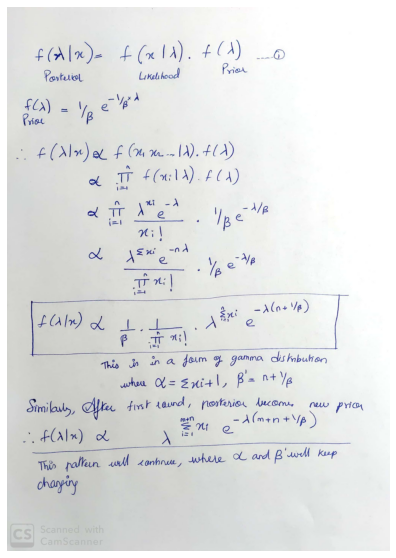

In [107]:
img=mpimg.imread(root_path + '/data/project5inf.jpg')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)

MAP Estimation for First Round is 41
MAP Estimation for Second Round is 39
MAP Estimation for Third Round is 37
MAP Estimation for Fourth Round is 36


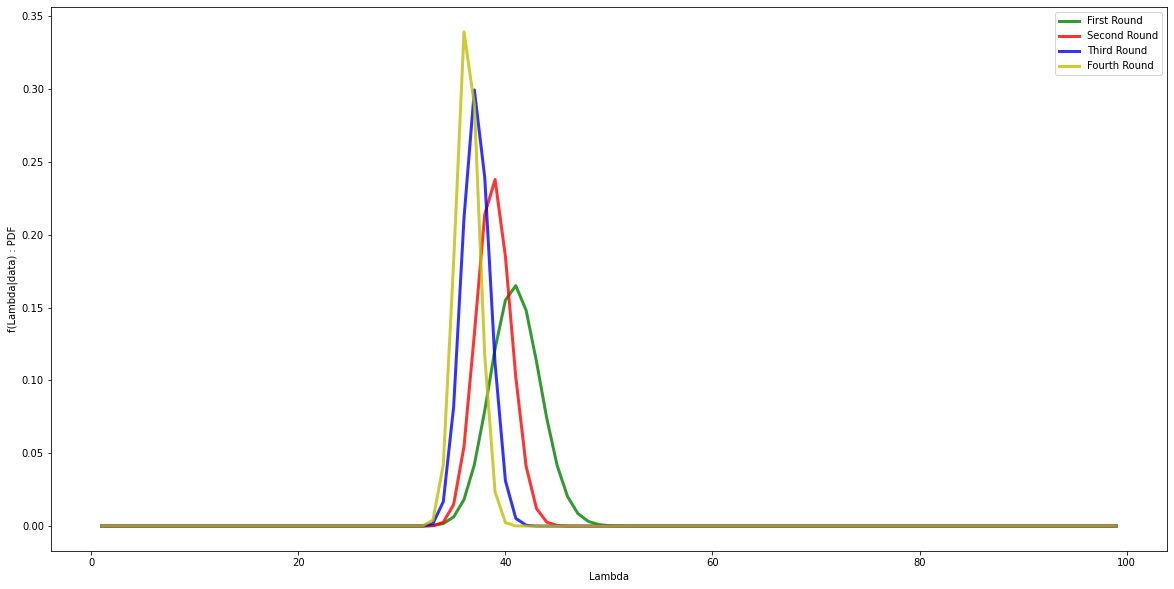

In [108]:
def find_map(x, alpha, scale_):
  max = 0
  lambda_ = 0
  for i in x:
    f_lambda = gamma.pdf(i, alpha, scale=scale_)
    if f_lambda > max:
      max = f_lambda
      lambda_ = i
  return lambda_

colors = ['-g', '-r', '-b', '-y']
legends = ['First Round', 'Second Round', 'Third Round', 'Fourth Round']
lamda_mme = sum(ccases[0:7])/7
beta = lamda_mme
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
x = list(range(1,100))

for i in range(1, 5):
  n = 7
  alpha = sum(ccases[0:7 * i]) + 1
  g_beta = n*i + 1/beta
  ax.plot(x, gamma.pdf(x, alpha, scale=1/g_beta), colors[i - 1], lw=3, alpha=0.8)
  ax.legend(legends)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('f(Lambda|data) : PDF')
  map = find_map(x, alpha, 1/g_beta)
  print('MAP Estimation for {} is {}'.format(legends[i-1], map))

# Sample Inferences

### 1. Creative Sample Inference 1
#### One-Sided Z-test to verify Real-Time Events like rise in New Testing Facility/Equipments
#### San francisco increased it's testing facilities and equipments on April 22 
##### https://www.nbcbayarea.com/news/local/san-francisco/sf-increases-testing-for-all-essential-workers-residents-with-covid-19-symptoms/2277523/
##### We expect a serious rise in cases after that event
##### We check whether weakly mean of cases after the news is greater than weakly mean cases before the event
##### $H_0: \hat\mu \geq \mu_0$
##### $H_1: \hat\mu < \mu_0$


##### We know that regardless of the original distribution of X, we know by Central Limit Theorem, that $\overline{X} \sim N(\mu, \dfrac{\sigma^2}{n})$
##### where $\mu$ is true mean and $\sigma^2$ is true standard deviation

##### Hence, Z-test is applicable here

In [0]:
confirm_cases = cases_df[cases_df["Case Disposition"] == "Confirmed"]
case_counts = confirm_cases.groupby('Date')['Case Count'].sum().reset_index()

In [0]:
# lockdown_effective_date = datetime.datetime(2020, 3, 17)
effective_date = datetime.datetime(2020, 4, 22)
# effective_date = datetime.datetime(2020, 3, 17)
before_start = effective_date - datetime.timedelta(days=7)
before_end = before_start + datetime.timedelta(days=6)

after_start = effective_date + datetime.timedelta(days=1)
after_end = after_start + datetime.timedelta(days=6)

mean_before = case_counts[(case_counts["Date"] >= before_start) & (case_counts["Date"] <= before_end)]["Case Count"].mean()
mean_after = case_counts[(case_counts["Date"] >= after_start) & (case_counts["Date"] <= after_end)]["Case Count"].mean()


In [0]:
X = case_counts["Case Count"].astype(float).to_numpy()
e_of_x = np.mean(X)
e_of_x_square = np.mean(np.multiply(X, X))

true_standard_deviation_of_X = math.sqrt(e_of_x_square - (e_of_x**2))

z_statistic = (mean_after - mean_before)/(true_standard_deviation_of_X / math.sqrt(7))

In [112]:
z_statistic

0.34153749994694627

##### Since this is a left tailed test we are going to check whether z-statistic $ \leq -Z_{\alpha}$ to reject the null hypothesis
##### i.e. z-statistic $\leq -1.645$ for significance level of 0.05

In [113]:
z_threshold = -1.645 # for significance of 0.05
if z_statistic < z_threshold:
    print("We reject the null hypothesis, there is no effect of new testing facilities")
else:
    print("We failed to reject null hypothesis, there is serious rise in new cases as new testing facilities or equipments increase")

We failed to reject null hypothesis, there is serious rise in new cases as new testing facilities or equipments increase


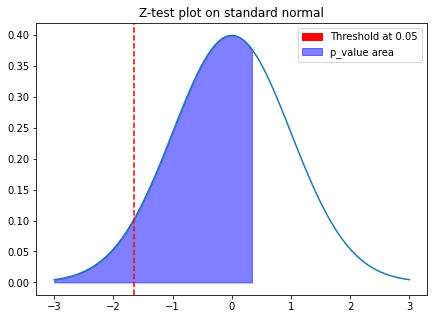

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import matplotlib.patches as mpatches

figures, axes = plt.subplots(figsize=(7, 5))

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
axes.plot(x, stats.norm.pdf(x, mu, sigma))

x_till_statistic = np.arange(-3, z_statistic, 0.001)
y_till_statistic = stats.norm.pdf(x_till_statistic, mu, sigma)

axes.fill_between(x_till_statistic, y_till_statistic,0, alpha=0.5, color='b')
axes.axvline(x=z_threshold, linestyle='--', color='r', gid='threshold')


red_patch = mpatches.Patch(color='red', label='Threshold at 0.05')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='p_value area')
axes.legend(handles=[red_patch, blue_patch])
axes.set_title("Z-test plot on standard normal")

plt.show()

### 2. Creative Sample Inferences 2
## Chi-square Test to check whether Gender is independent of covid-cases in San-Francisco

##### $H_0: Gender \perp \!\!\! \perp  Corona$
##### $H_1: Gender$ x $\perp \!\!\! \perp  Corona$ (Not independent)

#### Citing data for demographics
Gender Corona data: https://www.opendatanetwork.com/entity/1600000US0667000/San_Francisco_CA/demographics.population.count?year=2018

Case Corona date: https://worldpopulationreview.com/us-cities/san-francisco-population/

In [0]:
gender_data = pd.read_csv(root_path + '/data/COVID-19_Cases_Summarized_by_Age_Group_and_Gender.csv', index_col=0)
gender_data["Confirmed Cases"] = gender_data["Confirmed Cases"].astype(int)

In [0]:
gender_cases = gender_data.groupby(["Gender"]).agg({"Confirmed Cases": "sum"}).reset_index()

male_cases = gender_cases[gender_cases["Gender"] == "Male"].iloc[0]['Confirmed Cases']
female_cases = gender_cases[gender_cases["Gender"] == "Female"].iloc[0]['Confirmed Cases']

total_female = 426074
total_male = 443970

non_corona_female = total_female - female_cases
non_corona_male = total_male - male_cases

observed_matrix = [[female_cases, non_corona_female], [male_cases, non_corona_male]]

total = float(total_male + total_female)

In [117]:
q_statistic = 0.0
total_row = [sum(observed_matrix[0]), sum(observed_matrix[1])]
total_col = [male_cases + female_cases, non_corona_male + non_corona_female]
for i in range(2):
    for j in range(2):
        expected = float(total_row[i]) * float(total_col[j]) / total
        observed = observed_matrix[i][j]
        q_statistic = q_statistic + (((expected - observed) ** 2) / expected)

degrees_of_freedom = (2 - 1) * (2 - 1)

print("Q statistic observed: " + str(q_statistic) + " Degrees of Freedom: " + str(degrees_of_freedom))

Q statistic observed: 60.29022765469443 Degrees of Freedom: 1


#### Only for fetching p-value from Chi-Square distribution we are using scipy library

In [118]:
from scipy import stats
p_value = 1 - stats.chi2.cdf(q_statistic, degrees_of_freedom)

print("P-value observed against q_statistic: " + str(p_value))

if p_value < 0.05:
    print("Gender is independent of Corona cases, it impacts both the genders almost equally")
else:
    print("Gender is dependent of Corona cases, it may not impact both the genders almost equally")

P-value observed against q_statistic: 8.215650382226158e-15
Gender is independent of Corona cases, it impacts both the genders almost equally


#### Hence, we conclude that it is not necessary to corona to be affected on males or females more
#### The effect of corona on the basis of gender is more or less same for both the genders
#### Below is the Plot for chi-square Observed Matrix

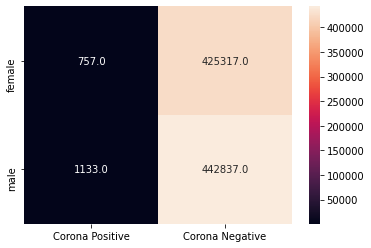

In [119]:
df = pd.DataFrame({"Corona Positive": [observed_matrix[i][0] for i in range(2)], "Corona Negative": [observed_matrix[i][1] for i in range(2)]}, index=["female", "male"])
sns.heatmap(df, annot=True, fmt=".01f")

### 3. Creative Sample Inference 3

####Performing Unpaired T-Test on Covid Cases, based on method of transmisson.

**Has the lockdown affected the way corona is transmitted ?**

We want to infer if the lockdown has affected the way corona is transitted i.e by contact or by community. So we perform Unpaired T-Test for Each of these transmission types for dates before lockdown and after lockdown. Two Dates Ranges are taken, (2020-03-05 - 2020-03-27) and (2020-04-15 - 2020-05-08). The first range corresponds to the dates before lockdown and the second dates are when lockdown is in effect. Lockdown was introduced on 2020-03-17, we add a 10 day buffer to account for people who contracted corona earlier but did not show symptoms

Same notations for before and after lockdown


**Hypotheses:**

$H_0: \mu_x = \mu_y$  
$H_1: \mu_x \neq \mu_y$  
$\bar D= \bar X - \bar Y$ 

$\mu_x$ is mean of the community transmissions

$\mu_y$ is mean of transmission by contact

#### Perform the Experiment

In [120]:
def loadCovidDataset(path):
    # cases_df has already been preprocessed in pre-processing phase and Outliers have been removed
    return cases_df    

def preprocessCovidDataset(covidDatatset, startDate, midDate1, midDate2, endDate):
    covidDatatset["Date"] = pd.to_datetime(covidDatatset["Date"], format="%Y/%m/%d")
    covidDatatsetFiltered = covidDatatset[((covidDatatset['Date'] >= startDate) & (covidDatatset['Date'] <= midDate1)) | ((covidDatatset['Date'] >= midDate2) & (covidDatatset['Date'] <= endDate)) ]
    covidDatatsetFiltered = covidDatatsetFiltered.groupby(['Date','Transmission Category','Case Disposition'], as_index=False)['Case Count'].sum()
    return covidDatatsetFiltered

def construct2DistributionsForCasesAndDeaths(covidDatatsetFiltered, startDate, midDate1, midDate2, endDate):
    sampleDistributions = {}
    covidDatatsetCases = covidDatatsetFiltered[(covidDatatsetFiltered['Case Disposition'] == 'Confirmed')].drop(['Case Disposition'], axis=1)
    covidDatatsetCommunityCases = covidDatatsetCases[(covidDatatsetCases['Transmission Category'] == 'Community')].drop(['Transmission Category'], axis=1)
    covidDatatsetContactCases = covidDatatsetCases[(covidDatatsetCases['Transmission Category'] == 'From Contact')].drop(['Transmission Category'], axis=1)
    covidDatatsetUnknownCases = covidDatatsetCases[(covidDatatsetCases['Transmission Category'] == 'Unknown')].drop(['Transmission Category'], axis=1)
    
    sampleDistributions["covidDatatsetCommunityCasesFirstHalf"] = covidDatatsetCommunityCases[(covidDatatsetCommunityCases['Date'] >= startDate) & (covidDatatsetCommunityCases['Date'] <= midDate1)]['Case Count'].tolist()
    sampleDistributions["covidDatatsetContactCasesFirstHalf"] = covidDatatsetContactCases[(covidDatatsetContactCases['Date'] >= startDate) & (covidDatatsetContactCases['Date'] <= midDate1)]['Case Count'].tolist()
    sampleDistributions["covidDatatsetUnknownCasesFirstHalf"] = covidDatatsetUnknownCases[(covidDatatsetUnknownCases['Date'] >= startDate) & (covidDatatsetUnknownCases['Date'] <= midDate1)]['Case Count'].tolist()

    sampleDistributions["covidDatatsetCommunityCasesSecondHalf"] = covidDatatsetCommunityCases[(covidDatatsetCommunityCases['Date'] >= midDate2) & (covidDatatsetCommunityCases['Date'] <= endDate)]['Case Count'].tolist() 
    sampleDistributions["covidDatatsetContactCasesSecondHalf"] = covidDatatsetContactCases[(covidDatatsetContactCases['Date'] >= midDate2) & (covidDatatsetContactCases['Date'] <= endDate)]['Case Count'].tolist()
    sampleDistributions["covidDatatsetUnknownCasesSecondHalf"] = covidDatatsetUnknownCases[(covidDatatsetUnknownCases['Date'] >= midDate2) & (covidDatatsetUnknownCases['Date'] <= endDate)]['Case Count'].tolist()
    return sampleDistributions

def performTtest(X, Y):
    n = len(X)
    m = len(Y)
    X_bar = np.mean(X)
    Y_bar = np.mean(Y)
    sample_variance_x = 1/n * np.sum(np.square(X - X_bar))
    sample_variance_y = 1/m * np.sum(np.square(Y - Y_bar))
    se_hat = np.sqrt(sample_variance_x / n + sample_variance_y / m)
    t = np.abs((X_bar - Y_bar) / se_hat)
    return t

def performTtests(sampleDistributions):
    print("T-Value for Community vs Contact before lockdown ",performTtest(sampleDistributions["covidDatatsetCommunityCasesFirstHalf"],sampleDistributions["covidDatatsetContactCasesFirstHalf"]))
    print("T-Value for Community vs Contact after lockdown ",performTtest(sampleDistributions["covidDatatsetCommunityCasesSecondHalf"],sampleDistributions["covidDatatsetContactCasesSecondHalf"]))

startDate = '2020-03-05'
midDate1 = '2020-03-27'
midDate2 = '2020-04-15'
endDate = '2020-05-08'
path = '/data/COVID-19_Cases_Summarized_by_Date__Transmission_and_Case_Disposition.csv'
covidDatatset = loadCovidDataset(path)
covidDatatsetFiltered = preprocessCovidDataset(covidDatatset, startDate, midDate1, midDate2, endDate)
sampleDistributions = construct2DistributionsForCasesAndDeaths(covidDatatsetFiltered, startDate, midDate1, midDate2, endDate)
performTtests(sampleDistributions)

T-Value for Community vs Contact before lockdown  4.064666049822045
T-Value for Community vs Contact after lockdown  1.832903020648693


#### Inference

**For T-Value for Community vs Contact before lockdown  4.06467**

For $\alpha = 0.05$ and $df = n+m-2 = 32$, $t_{df,\alpha/2} = 2.037$  
Since the T's statistic $|t| \gt t_{n+m-2, \alpha/2}$ we accept the null hypothesis $H_0$ and conclude that $\mu_x \ne \mu_y$

**T-Value for Community vs Contact after lockdown  1.833**

For $\alpha = 0.05$ and $df = n+m-2 = 35$, $t_{df,\alpha/2} = 2.030$  
Since the T's statistic $|t| \leq t_{n+m-2, \alpha/2}$ we fail to reject the null hypothesis $H_0$ and conclude that $\mu_x = \mu_y$

**Conclusion**:

Before lockdown the means are not the same, community seems to be higher as observed from the T-value. 

But after lockdown the trasnmission by community and contact becomes similar.